In [2]:
import sys
import numpy as np
import cv2
import os
import shutil
import pandas as pd
from tqdm import tqdm
import yaml


def show_image(img):
    cv2.namedWindow("Image", cv2.WINDOW_NORMAL)  # Create window with freedom of dimensions
    imS = cv2.resize(img, (1920, 1080))  # Resize image
    cv2.imshow("Image", imS)  # Show image
    print('Press Esc key to kill')
    cv2.waitKey(0)
    cv2.destroyAllWindows()


def f(x, y, A, sigma_x, sigma_y, theta):
    # Gaussian function obtained from https://www.astro.rug.nl/~vogelaar/Gaussians2D/2dgaussians.html
    theta = np.radians(theta)
    sigx2 = sigma_x ** 2
    sigy2 = sigma_y ** 2
    a = np.cos(theta) ** 2 / (2 * sigx2) + np.sin(theta) ** 2 / (2 * sigy2)
    b = np.sin(theta) ** 2 / (2 * sigx2) + np.cos(theta) ** 2 / (2 * sigy2)
    c = np.sin(2 * theta) / (4 * sigx2) - np.sin(2 * theta) / (4 * sigy2)

    expo = -a * x ** 2 - b * y ** 2 - 2 * c * x * y
    return A * np.exp(expo)


def random_cell():
    N = np.random.randint(100, 150)
    x = np.linspace(-5, 5, N)
    y = np.linspace(-3, 3, N)

    theta = np.random.randint(0, 360)  # deg
    sigx = np.random.uniform(0.5, 1)
    sigy = np.random.uniform(0.5, 1)
    A = 1
    Xg, Yg = np.meshgrid(x, y)

    Z = f(Xg, Yg, A, sigx, sigy, theta)

    return Z, N


def add_cells(img, n_cells):
    H, W, _ = img.shape
    centroids = []
    bboxes = []  # Store bounding boxes for YOLO format
    
    for _ in range(n_cells):
        try:
            roi = [np.random.randint(H), np.random.randint(W)]
            cell, size = random_cell()
            
            # Ensure the cell fits within image boundaries
            if roi[0] + size >= H or roi[1] + size >= W:
                continue
                
            patch = img[roi[0]:roi[0] + size, roi[1]:roi[1] + size, :]
            max_val_patch = patch.max()
            max_val_cell = 255 - max_val_patch
            cell = cell * max_val_cell
            patch[:, :, 1] = patch[:, :, 1] + cell
            img[roi[0]:roi[0] + size, roi[1]:roi[1] + size, :] = patch

            center = [roi[0] + int(size / 2), roi[1] + int(size / 2)]
            centroids.append(center)
            
            # Create bounding box (x_min, y_min, x_max, y_max)
            bbox = [roi[1], roi[0], roi[1] + size, roi[0] + size]
            bboxes.append(bbox)
            
        except:
            pass

    return img, centroids, bboxes


def put_marks(img, centroids):
    markerType = cv2.MARKER_STAR
    color = (0, 0, 255)
    markerSize = 15
    thickness = 2

    for c in centroids:
        y, x = c
        cv2.drawMarker(img, (x, y), color, markerType, markerSize, thickness)

    return img


def create_data_image(background_path, n_cells):
    backgrounds_paths = [os.path.join(background_path, file) for file in os.listdir(background_path)]
    bg_path = np.random.choice(backgrounds_paths)

    bg = cv2.imread(bg_path)
    img, centroids, bboxes = add_cells(bg, n_cells)

    return img, centroids, bboxes


def check_folder(path):
    if not os.path.exists(path):
        os.mkdir(path)
        os.mkdir(os.path.join(path, 'images'))
    else:
        print(f'The folder {path} already exists. It has {len(os.listdir(path))} elements.')
        print('Do you want to remove its content? y/n')
        if input('') == 'y':
            shutil.rmtree(path)
            os.mkdir(path)
            os.mkdir(os.path.join(path, 'images'))
        else:
            sys.exit()


def create_dataset(background_path, output_path, N=100, max_n=2000, yolo_format=False, train_split=0.8):
    check_folder(output_path)
    
    if yolo_format:
        # Create YOLOv8 structure
        yolo_path = create_yolo_structure(output_path)
        create_dataset_yaml(yolo_path)
        
        # Calculate split
        train_count = int(N * train_split)
        
        print(f"Creating YOLOv8 dataset with {train_count} training and {N-train_count} validation images")
    else:
        # Original structure
        images_path = os.path.join(output_path, 'images')

    range_list = np.linspace(0, max_n, N, dtype=int)
    id_ = 1
    dataset_dic = {'file': [], 'gt': [], 'centroids': [], 'bboxes': []}

    for i, n in enumerate(tqdm(range_list)):
        image, centroids, bboxes = create_data_image(background_path, n)
        
        if yolo_format:
            # Determine if this image goes to train or val
            is_train = i < train_count
            split_folder = 'train' if is_train else 'val'
            
            # Save image
            img_path = os.path.join(yolo_path, 'images', split_folder, f'{id_}.png')
            cv2.imwrite(img_path, image)
            
            # Create and save YOLO annotation
            if bboxes:  # Only create annotation if there are bounding boxes
                img_height, img_width = image.shape[:2]
                annotation = create_yolo_annotation(bboxes, img_width, img_height)
                
                label_path = os.path.join(yolo_path, 'labels', split_folder, f'{id_}.txt')
                with open(label_path, 'w') as f:
                    f.write(annotation)
            else:
                # Create empty annotation file for images with no bacteria
                label_path = os.path.join(yolo_path, 'labels', split_folder, f'{id_}.txt')
                with open(label_path, 'w') as f:
                    f.write('')
                    
        else:
            # Original format
            img_path = os.path.join(images_path, f'{id_}.png')
            cv2.imwrite(img_path, image)

        dataset_dic['file'].append(f'{id_}.png')
        dataset_dic['gt'].append(len(centroids))
        dataset_dic['centroids'].append(centroids)
        dataset_dic['bboxes'].append(bboxes)

        id_ += 1

    # Save metadata CSV
    df = pd.DataFrame(dataset_dic)
    csv_path = os.path.join(yolo_path if yolo_format else output_path, 'artificial_fluorescent_dataset.csv')
    df.to_csv(csv_path, index=False)
    
    if yolo_format:
        print(f"YOLOv8 dataset created at: {yolo_path}")
        print(f"Dataset configuration: {os.path.join(yolo_path, 'dataset.yaml')}")
        print(f"Training images: {train_count}")
        print(f"Validation images: {N-train_count}")
    
    return yolo_path if yolo_format else output_path


def test():
    img_2, centroids, bboxes = create_data_image('DATASET/Background', 500)
    show_image(img_2)
    show_image(put_marks(img_2, centroids))


def bbox_to_yolo(bbox, img_width, img_height):
    """Convert bounding box to YOLO format (normalized)"""
    x_min, y_min, x_max, y_max = bbox
    
    # Calculate center coordinates and dimensions
    x_center = (x_min + x_max) / 2.0
    y_center = (y_min + y_max) / 2.0
    width = x_max - x_min
    height = y_max - y_min
    
    # Normalize coordinates
    x_center /= img_width
    y_center /= img_height
    width /= img_width
    height /= img_height
    
    return x_center, y_center, width, height


def create_yolo_annotation(bboxes, img_width, img_height, class_id=0):
    """Create YOLO format annotation string"""
    annotations = []
    for bbox in bboxes:
        x_center, y_center, width, height = bbox_to_yolo(bbox, img_width, img_height)
        annotations.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
    return "\n".join(annotations)


def create_yolo_structure(output_path):
    """Create YOLOv8 directory structure"""
    yolo_path = os.path.join(output_path, 'yolo_dataset')
    
    # Create main directories
    os.makedirs(os.path.join(yolo_path, 'images', 'train'), exist_ok=True)
    os.makedirs(os.path.join(yolo_path, 'images', 'val'), exist_ok=True)
    os.makedirs(os.path.join(yolo_path, 'labels', 'train'), exist_ok=True)
    os.makedirs(os.path.join(yolo_path, 'labels', 'val'), exist_ok=True)
    
    return yolo_path


def create_dataset_yaml(yolo_path, class_names=['bacteria']):
    """Create dataset.yaml file for YOLOv8"""
    dataset_config = {
        'path': yolo_path,
        'train': 'images/train',
        'val': 'images/val',
        'nc': len(class_names),  # number of classes
        'names': class_names
    }
    
    yaml_path = os.path.join(yolo_path, 'dataset.yaml')
    with open(yaml_path, 'w') as f:
        yaml.dump(dataset_config, f, default_flow_style=False)
    
    return yaml_path


In [3]:
#!/usr/bin/env python3
"""
Visualization script to show bounding boxes on generated images
"""
import cv2
import numpy as np
import os


def draw_bounding_boxes(image, bboxes, color=(0, 255, 0), thickness=2):
    """Draw bounding boxes on image"""
    img_with_boxes = image.copy()
    
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        cv2.rectangle(img_with_boxes, (x_min, y_min), (x_max, y_max), color, thickness)
    
    return img_with_boxes


def visualize_yolo_annotations(yolo_label_path, image_path):
    """Visualize YOLO format annotations on image"""
    # Read image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not load image: {image_path}")
        return None
    
    img_height, img_width = image.shape[:2]
    
    # Read YOLO annotations
    if not os.path.exists(yolo_label_path):
        print(f"No annotations found: {yolo_label_path}")
        return image
    
    with open(yolo_label_path, 'r') as f:
        lines = f.readlines()
    
    # Convert YOLO format to pixel coordinates
    for line in lines:
        parts = line.strip().split()
        if len(parts) != 5:
            continue
            
        class_id, x_center, y_center, width, height = map(float, parts)
        
        # Convert normalized coordinates to pixel coordinates
        x_center *= img_width
        y_center *= img_height
        width *= img_width
        height *= img_height
        
        # Calculate bounding box corners
        x_min = int(x_center - width / 2)
        y_min = int(y_center - height / 2)
        x_max = int(x_center + width / 2)
        y_max = int(y_center + height / 2)
        
        # Draw bounding box
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        
        # Draw center point
        cv2.circle(image, (int(x_center), int(y_center)), 3, (0, 0, 255), -1)
    
    return image


def create_sample_visualization():
    """Create a sample image with visualizations"""
    print("Creating sample visualization...")
    
    # Generate a sample image
    image, centroids, bboxes = create_data_image('/kaggle/input/images/DATASET/Background', 50)
    
    # Original image
    cv2.imwrite('sample_original.png', image)
    
    # Image with bounding boxes
    image_with_boxes = draw_bounding_boxes(image, bboxes)
    cv2.imwrite('sample_with_bboxes.png', image_with_boxes)
    
    # Image with centroids
    image_with_centroids = image.copy()
    for centroid in centroids:
        y, x = centroid
        cv2.circle(image_with_centroids, (x, y), 5, (0, 0, 255), -1)
    cv2.imwrite('sample_with_centroids.png', image_with_centroids)
    
    # Combined visualization
    combined = image.copy()
    # Draw bounding boxes
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        cv2.rectangle(combined, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    # Draw centroids
    for centroid in centroids:
        y, x = centroid
        cv2.circle(combined, (x, y), 3, (0, 0, 255), -1)
    cv2.imwrite('sample_combined.png', combined)
    
    print(f"Sample visualizations created:")
    print(f"  - sample_original.png (original image)")
    print(f"  - sample_with_bboxes.png (with bounding boxes)")
    print(f"  - sample_with_centroids.png (with centroids)")
    print(f"  - sample_combined.png (combined visualization)")
    print(f"  - Generated {len(bboxes)} bacteria")


if __name__ == '__main__':
    create_sample_visualization()


Creating sample visualization...
Sample visualizations created:
  - sample_original.png (original image)
  - sample_with_bboxes.png (with bounding boxes)
  - sample_with_centroids.png (with centroids)
  - sample_combined.png (combined visualization)
  - Generated 46 bacteria


In [8]:
"""
Example script showing how to create datasets in both formats
"""
import os


def create_yolo_dataset():
    """Create a YOLOv8 format dataset"""
    print("Creating YOLOv8 format dataset...")
    
    background_path = '/kaggle/input/images/DATASET/Background'
    output_path = '/kaggle/working/DatasetBacteria'
    N = 500  # Number of images
    max_cells = 5000  # Max bacteria per image
    
    dataset_path = create_dataset(
        background_path=background_path,
        output_path=output_path,
        N=N,
        max_n=max_cells,
        yolo_format=True,
        train_split=0.8
    )
    
    print(f"\nYOLOv8 dataset created at: {dataset_path}")
    print(f"Dataset structure:")
    print(f"  {dataset_path}/images/train/  - Training images")
    print(f"  {dataset_path}/images/val/    - Validation images")
    print(f"  {dataset_path}/labels/train/  - Training labels")
    print(f"  {dataset_path}/labels/val/    - Validation labels")
    print(f"  {dataset_path}/dataset.yaml   - Dataset configuration")
    
    return dataset_path


def create_original_dataset():
    """Create original format dataset"""
    print("Creating original format dataset...")
    
    background_path = '/kaggle/input/images/DATASET/Background'
    output_path = '/kaggle/working/original_bacteria_dataset'
    N = 500
    max_cells = 2000
    
    dataset_path = create_dataset(
        background_path=background_path,
        output_path=output_path,
        N=N,
        max_n=max_cells,
        yolo_format=False
    )
    
    print(f"\nOriginal format dataset created at: {dataset_path}")
    return dataset_path


def show_training_commands(yolo_dataset_path):
    """Show YOLOv8 training commands"""
    print("\n" + "="*60)
    print("YOLOv8 TRAINING COMMANDS")
    print("="*60)
    
    yaml_path = os.path.join(yolo_dataset_path, 'dataset.yaml')
    
    print(f"\n1. Train YOLOv8 Nano model:")
    print(f"   yolo detect train data={yaml_path} model=yolov8n.pt epochs=100 imgsz=640")
    
    print(f"\n2. Train YOLOv8 Small model:")
    print(f"   yolo detect train data={yaml_path} model=yolov8s.pt epochs=100 imgsz=640")
    
    print(f"\n3. Train YOLOv8 Medium model:")
    print(f"   yolo detect train data={yaml_path} model=yolov8m.pt epochs=100 imgsz=640")
    
    print(f"\n4. Resume training:")
    print(f"   yolo detect train resume model=runs/detect/train/weights/last.pt")
    
    print(f"\n5. Validate model:")
    print(f"   yolo detect val model=runs/detect/train/weights/best.pt data={yaml_path}")
    
    print(f"\n6. Make predictions:")
    print(f"   yolo detect predict model=runs/detect/train/weights/best.pt source='path/to/test/images'")


if __name__ == '__main__':
    print("Artificial Fluorescent Dataset Creator")
    print("=====================================")
    
    # Create YOLOv8 format dataset
    yolo_path = create_yolo_dataset()
    
    # Create original format dataset
    original_path = create_original_dataset()
    
    # Show training commands
    show_training_commands(yolo_path)
    
    print(f"\n\nBoth datasets created successfully!")
    print(f"YOLOv8 format: {yolo_path}")
    print(f"Original format: {original_path}")


Artificial Fluorescent Dataset Creator
Creating YOLOv8 format dataset...
Creating YOLOv8 dataset with 400 training and 100 validation images


100%|██████████| 500/500 [12:38<00:00,  1.52s/it]


YOLOv8 dataset created at: /kaggle/working/DatasetBacteria/yolo_dataset
Dataset configuration: /kaggle/working/DatasetBacteria/yolo_dataset/dataset.yaml
Training images: 400
Validation images: 100

YOLOv8 dataset created at: /kaggle/working/DatasetBacteria/yolo_dataset
Dataset structure:
  /kaggle/working/DatasetBacteria/yolo_dataset/images/train/  - Training images
  /kaggle/working/DatasetBacteria/yolo_dataset/images/val/    - Validation images
  /kaggle/working/DatasetBacteria/yolo_dataset/labels/train/  - Training labels
  /kaggle/working/DatasetBacteria/yolo_dataset/labels/val/    - Validation labels
  /kaggle/working/DatasetBacteria/yolo_dataset/dataset.yaml   - Dataset configuration
Creating original format dataset...


100%|██████████| 500/500 [08:52<00:00,  1.06s/it]



Original format dataset created at: /kaggle/working/original_bacteria_dataset

YOLOv8 TRAINING COMMANDS

1. Train YOLOv8 Nano model:
   yolo detect train data=/kaggle/working/DatasetBacteria/yolo_dataset/dataset.yaml model=yolov8n.pt epochs=100 imgsz=640

2. Train YOLOv8 Small model:
   yolo detect train data=/kaggle/working/DatasetBacteria/yolo_dataset/dataset.yaml model=yolov8s.pt epochs=100 imgsz=640

3. Train YOLOv8 Medium model:
   yolo detect train data=/kaggle/working/DatasetBacteria/yolo_dataset/dataset.yaml model=yolov8m.pt epochs=100 imgsz=640

4. Resume training:
   yolo detect train resume model=runs/detect/train/weights/last.pt

5. Validate model:
   yolo detect val model=runs/detect/train/weights/best.pt data=/kaggle/working/DatasetBacteria/yolo_dataset/dataset.yaml

6. Make predictions:
   yolo detect predict model=runs/detect/train/weights/best.pt source='path/to/test/images'


Both datasets created successfully!
YOLOv8 format: /kaggle/working/DatasetBacteria/yolo_data

In [7]:
!rm -rf /kaggle/working/DatasetBacteria

# YOLO here

In [4]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00:00:010:02m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.0 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 25.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 3.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: n

In [5]:
import os
import yaml
from ultralytics import YOLO
import cv2
import numpy as np
from pathlib import Path

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [7]:
class BacteriaDetector:
    def __init__(self, dataset_path, model_size='n'):
        """
        Initialize the bacteria detector
        
        Args:
            dataset_path: Path to your YOLOv8 dataset folder
            model_size: YOLOv8 model size ('n', 's', 'm', 'l', 'x')
        """
        self.dataset_path = Path(dataset_path)
        self.model_size = model_size
        self.model = None
        self.trained_model_path = None
        
    def create_dataset_yaml(self):
        """Create the dataset.yaml file for bacteria detection (only if it doesn't exist)"""
        yaml_path = self.dataset_path / 'dataset.yaml'
        
        if yaml_path.exists():
            print(f"Dataset.yaml already exists at {yaml_path}")
            return yaml_path
            
        yaml_content = {
            'path': str(self.dataset_path.absolute()),
            'train': 'train/images',
            'val': 'val/images',
            'test': 'test/images',  # Optional
            'nc': 1,  # Number of classes (only bacteria)
            'names': ['bacteria']  # Class names
        }
        
        with open(yaml_path, 'w') as f:
            yaml.dump(yaml_content, f, default_flow_style=False)
        
        print(f"Created dataset.yaml at {yaml_path}")
        return yaml_path
    
    def train_model(self, epochs=100, imgsz=640, batch_size=16, patience=15, save_period=5):
        """
        Train the YOLOv8 model for bacteria detection with early stopping and periodic saving
        
        Args:
            epochs: Number of training epochs
            imgsz: Image size for training
            batch_size: Batch size for training
            patience: Early stopping patience (number of epochs without improvement)
            save_period: Save model weights every N epochs
        """
        # Create dataset.yaml (only if it doesn't exist)
        yaml_path = self.dataset_path / 'dataset.yaml'
        if not yaml_path.exists():
            yaml_path = self.create_dataset_yaml()
        else:
            print(f"Using existing dataset.yaml at {yaml_path}")
        
        # Load YOLOv8 model
        model_name = f'yolov8{self.model_size}.pt'
        self.model = YOLO(model_name)
        
        print(f"Starting training with {model_name}")
        print(f"Dataset path: {yaml_path}")
        print(f"Training parameters:")
        print(f"  - Epochs: {epochs}")
        print(f"  - Image size: {imgsz}")
        print(f"  - Batch size: {batch_size}")
        print(f"  - Early stopping patience: {patience}")
        print(f"  - Save period: {save_period} epochs")
        
        # Train the model with enhanced settings
        results = self.model.train(
            data=str(yaml_path),
            epochs=epochs,
            imgsz=imgsz,
            batch=batch_size,
            name='bacteria_detector',
            patience=patience,  # Early stopping patience
            save=True,
            save_period=save_period,  # Save every N epochs
            verbose=True,
            plots=True,  # Generate training plots
            val=True,  # Validate during training
            exist_ok=True,  # Overwrite existing project
            pretrained=True,  # Use pretrained weights
            optimizer='AdamW',  # Use AdamW optimizer
            lr0=0.01,  # Initial learning rate
            lrf=0.01,  # Final learning rate factor
            momentum=0.937,  # Momentum
            weight_decay=0.0005,  # Weight decay
            warmup_epochs=3.0,  # Warmup epochs
            warmup_momentum=0.8,  # Warmup momentum
            warmup_bias_lr=0.1,  # Warmup bias learning rate
        )
        
        # Get the best model path
        self.trained_model_path = self.model.trainer.best
        
        print(f"\n{'='*50}")
        print(f"TRAINING COMPLETED!")
        print(f"{'='*50}")
        print(f"Best model saved at: {self.trained_model_path}")
        print(f"Training stopped at epoch: {self.model.trainer.epoch}")
        print(f"Best mAP50: {self.model.trainer.best_fitness}")
        
        # Save final model with custom name
        final_model_path = f"bacteria_detector_final_{self.model_size}.pt"
        self.model.save(final_model_path)
        print(f"Final model also saved as: {final_model_path}")
        
        return results
    
    def load_trained_model(self, model_path):
        """Load a previously trained model"""
        self.model = YOLO(model_path)
        self.trained_model_path = model_path
        print(f"Loaded trained model from: {model_path}")
    
    def detect_bacteria(self, image_path, conf_threshold=0.5, save_results=True):
        """
        Detect bacteria in an image and count them
        
        Args:
            image_path: Path to the image
            conf_threshold: Confidence threshold for detection
            save_results: Whether to save annotated image
        
        Returns:
            dict: Detection results with count and details
        """
        if self.model is None:
            raise ValueError("Model not loaded. Please train or load a model first.")
        
        # Run inference
        results = self.model(image_path, conf=conf_threshold)
        
        # Process results
        detection_info = {
            'image_path': image_path,
            'bacteria_count': 0,
            'detections': [],
            'confidence_scores': []
        }
        
        for result in results:
            boxes = result.boxes
            if boxes is not None:
                detection_info['bacteria_count'] = len(boxes)
                
                for box in boxes:
                    # Get bounding box coordinates
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                    conf = box.conf[0].cpu().numpy()
                    
                    detection_info['detections'].append({
                        'bbox': [float(x1), float(y1), float(x2), float(y2)],
                        'confidence': float(conf)
                    })
                    detection_info['confidence_scores'].append(float(conf))
        
        # Save annotated image if requested
        if save_results:
            annotated = results[0].plot()
            output_path = f"bacteria_detected_{Path(image_path).stem}.jpg"
            cv2.imwrite(output_path, annotated)
            detection_info['annotated_image_path'] = output_path
            print(f"Annotated image saved as: {output_path}")
        
        return detection_info
    
    def batch_detect(self, image_folder, conf_threshold=0.5):
        """
        Detect bacteria in multiple images
        
        Args:
            image_folder: Path to folder containing images
            conf_threshold: Confidence threshold for detection
        
        Returns:
            list: List of detection results for each image
        """
        if self.model is None:
            raise ValueError("Model not loaded. Please train or load a model first.")
        
        image_folder = Path(image_folder)
        image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
        
        results = []
        for img_path in image_folder.iterdir():
            if img_path.suffix.lower() in image_extensions:
                try:
                    detection_result = self.detect_bacteria(
                        str(img_path), 
                        conf_threshold=conf_threshold,
                        save_results=False
                    )
                    results.append(detection_result)
                    print(f"Processed {img_path.name}: {detection_result['bacteria_count']} bacteria detected")
                except Exception as e:
                    print(f"Error processing {img_path.name}: {e}")
        
        return results
    
    def print_summary(self, results):
        """Print summary of detection results"""
        if not results:
            print("No results to summarize")
            return
        
        total_bacteria = sum(r['bacteria_count'] for r in results)
        avg_bacteria = total_bacteria / len(results)
        avg_confidence = np.mean([
            np.mean(r['confidence_scores']) if r['confidence_scores'] else 0 
            for r in results
        ])
        
        print(f"\n=== BACTERIA DETECTION SUMMARY ===")
        print(f"Total images processed: {len(results)}")
        print(f"Total bacteria detected: {total_bacteria}")
        print(f"Average bacteria per image: {avg_bacteria:.2f}")
        print(f"Average confidence score: {avg_confidence:.3f}")
        print(f"===================================")

In [8]:
if __name__ == "__main__":
    # Initialize the detector
    detector = BacteriaDetector(
        dataset_path="/kaggle/working/DatasetBacteria/yolo_dataset",  # Replace with your dataset path
        model_size='n'  # Options: 'n', 's', 'm', 'l', 'x'
    )
    
    # Train the model with optimized early stopping
    print("Starting training...")
    training_results = detector.train_model(
        epochs=100,
        imgsz=640,
        batch_size=4,
        patience=15,  # Stop if no improvement for 15 epochs
        save_period=5  # Save weights every 5 epochs
    )

Starting training...
Using existing dataset.yaml at /kaggle/working/DatasetBacteria/yolo_dataset/dataset.yaml
Starting training with yolov8n.pt
Dataset path: /kaggle/working/DatasetBacteria/yolo_dataset/dataset.yaml
Training parameters:
  - Epochs: 100
  - Image size: 640
  - Batch size: 4
  - Early stopping patience: 15
  - Save period: 5 epochs
Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/DatasetBacteria/yolo_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015

100%|██████████| 755k/755k [00:00<00:00, 23.4MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/working/DatasetBacteria/yolo_dataset/labels/train.cache... 400 images, 1 backgrounds, 0 corrupt: 100%|██████████| 400/400 [00:00<?, ?it/s]

train: /kaggle/working/DatasetBacteria/yolo_dataset/images/train/261.png: 1 duplicate labels removed


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 422.1±277.3 MB/s, size: 12066.5 KB)


val: Scanning /kaggle/working/DatasetBacteria/yolo_dataset/labels/val.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]


Plotting labels to runs/detect/bacteria_detector/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/bacteria_detector
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100        13G      2.413      1.279      1.264       8781        640: 100%|██████████| 100/100 [00:45<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:13<00:00,  1.05s/it]

                   all        100     411346      0.728     0.0531      0.384      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      14.2G      1.959     0.8301      1.092       9662        640: 100%|██████████| 100/100 [00:35<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:13<00:00,  1.00s/it]

                   all        100     411346       0.99     0.0722      0.531      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      14.4G      1.872     0.8071      1.069  1.319e+04        640: 100%|██████████| 100/100 [00:34<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]

                   all        100     411346      0.991     0.0723      0.531      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      13.4G      1.751     0.7689      1.035       8082        640: 100%|██████████| 100/100 [00:34<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.00it/s]

                   all        100     411346      0.783     0.0571      0.416      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100        15G      1.745     0.7389      1.019  1.348e+04        640: 100%|██████████| 100/100 [00:34<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.05it/s]

                   all        100     411346      0.993     0.0724      0.532      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      13.2G      1.719     0.7401      1.032  1.015e+04        640: 100%|██████████| 100/100 [00:35<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.02it/s]

                   all        100     411346      0.986     0.0719      0.529      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      13.9G      1.661     0.7132      1.006   1.56e+04        640: 100%|██████████| 100/100 [00:34<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.02it/s]

                   all        100     411346      0.999     0.0729      0.536      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      15.1G      1.644     0.6912     0.9941  1.003e+04        640: 100%|██████████| 100/100 [00:35<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:13<00:00,  1.02s/it]

                   all        100     411346      0.979     0.0714      0.525      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      10.3G      1.572     0.6884     0.9826       7486        640: 100%|██████████| 100/100 [00:34<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.05it/s]

                   all        100     411346      0.999     0.0728      0.536      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      14.4G      1.539     0.6605     0.9699  1.047e+04        640: 100%|██████████| 100/100 [00:34<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]

                   all        100     411346          1     0.0729      0.536      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      14.9G      1.493     0.6605     0.9665   1.48e+04        640: 100%|██████████| 100/100 [00:34<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.06it/s]

                   all        100     411346      0.986     0.0719      0.528      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      10.9G      1.542     0.6644     0.9787  1.171e+04        640: 100%|██████████| 100/100 [00:34<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]

                   all        100     411346          1     0.0729      0.536      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      15.3G      1.503      0.642     0.9609  1.033e+04        640: 100%|██████████| 100/100 [00:34<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:11<00:00,  1.09it/s]

                   all        100     411346      0.992     0.0724      0.532       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      14.8G      1.479     0.6438     0.9543  1.202e+04        640: 100%|██████████| 100/100 [00:34<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.05it/s]

                   all        100     411346          1     0.0729      0.536      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      12.8G      1.414     0.6256     0.9459  1.131e+04        640: 100%|██████████| 100/100 [00:34<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]

                   all        100     411346      0.988      0.072      0.529      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      11.7G      1.451     0.6385     0.9545  1.267e+04        640: 100%|██████████| 100/100 [00:34<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.06it/s]

                   all        100     411346      0.999     0.0729      0.536      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      13.3G      1.571      0.657     0.9681       8513        640: 100%|██████████| 100/100 [00:34<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]

                   all        100     411346      0.996     0.0727      0.534      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      12.8G      1.428     0.6346     0.9469  1.227e+04        640: 100%|██████████| 100/100 [00:34<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]

                   all        100     411346      0.999     0.0729      0.536      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100        13G      1.383      0.603     0.9387  1.104e+04        640: 100%|██████████| 100/100 [00:34<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]

                   all        100     411346      0.988     0.0721       0.53      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      9.64G      1.416     0.6171     0.9441       6984        640: 100%|██████████| 100/100 [00:34<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.02it/s]

                   all        100     411346      0.997     0.0727      0.535       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      13.4G       1.39     0.5943     0.9343  1.052e+04        640:  80%|████████  | 80/100 [00:27<00:07,  2.66it/s]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     21/100      10.9G      1.403     0.5991     0.9392       6763        640: 100%|██████████| 100/100 [01:11<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]

                   all        100     411346          1     0.0729      0.536      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      11.9G      1.375     0.5988     0.9353  1.368e+04        640: 100%|██████████| 100/100 [00:35<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:11<00:00,  1.09it/s]

                   all        100     411346      0.999     0.0729      0.536       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      11.3G      1.346     0.5826     0.9229  1.571e+04        640: 100%|██████████| 100/100 [00:34<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.05it/s]

                   all        100     411346          1     0.0729      0.536      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      14.2G      1.328     0.5828     0.9217  1.847e+04        640: 100%|██████████| 100/100 [00:35<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:11<00:00,  1.08it/s]

                   all        100     411346          1     0.0729      0.536      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      12.4G      1.307     0.5699     0.9188       7796        640: 100%|██████████| 100/100 [00:34<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.06it/s]

                   all        100     411346      0.995     0.0726      0.534      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      14.8G      1.322     0.5729     0.9214  1.376e+04        640:  58%|█████▊    | 58/100 [00:19<00:12,  3.24it/s]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


     26/100      15.1G       1.32     0.5757     0.9256       8264        640: 100%|██████████| 100/100 [01:12<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.06it/s]

                   all        100     411346          1     0.0729      0.536      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      12.4G      1.341      0.585     0.9326  1.004e+04        640: 100%|██████████| 100/100 [00:34<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.05it/s]

                   all        100     411346          1     0.0729      0.536      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      11.7G      1.332     0.5707     0.9191  1.768e+04        640: 100%|██████████| 100/100 [00:34<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.06it/s]

                   all        100     411346      0.999     0.0729      0.536      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      11.7G      1.312     0.5682     0.9221  1.081e+04        640: 100%|██████████| 100/100 [00:35<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.06it/s]

                   all        100     411346          1     0.0729      0.536      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      12.2G      1.276     0.5586     0.9151       9297        640: 100%|██████████| 100/100 [00:34<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.06it/s]

                   all        100     411346      0.994     0.0725      0.533      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      15.5G        1.3     0.5636     0.9225       8142        640: 100%|██████████| 100/100 [00:34<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.06it/s]

                   all        100     411346      0.999     0.0729      0.536      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100        12G      1.274     0.5653     0.9189  1.004e+04        640: 100%|██████████| 100/100 [00:33<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:11<00:00,  1.10it/s]

                   all        100     411346          1     0.0729      0.536      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      13.1G      1.314     0.5588     0.9184  1.163e+04        640: 100%|██████████| 100/100 [00:35<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:11<00:00,  1.09it/s]

                   all        100     411346          1     0.0729      0.536      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      14.9G      1.283     0.5604     0.9144       6381        640: 100%|██████████| 100/100 [00:34<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.05it/s]

                   all        100     411346          1     0.0729      0.536      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      12.4G      1.306     0.5569     0.9196       6390        640: 100%|██████████| 100/100 [00:34<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.08it/s]

                   all        100     411346          1     0.0729      0.536      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      13.1G      1.254     0.5511     0.9103  1.032e+04        640: 100%|██████████| 100/100 [00:33<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.05it/s]

                   all        100     411346      0.999     0.0729      0.536      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100        13G      1.255     0.5427     0.9072       7565        640: 100%|██████████| 100/100 [00:33<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.05it/s]

                   all        100     411346          1     0.0729      0.536       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      10.5G      1.254     0.5497     0.9111       7855        640: 100%|██████████| 100/100 [00:34<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]

                   all        100     411346      0.998     0.0728      0.535      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100        12G      1.246     0.5424     0.9126       8502        640: 100%|██████████| 100/100 [00:33<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]

                   all        100     411346          1     0.0729      0.536       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      11.4G      1.263     0.5505     0.9143       8901        640: 100%|██████████| 100/100 [00:33<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]

                   all        100     411346          1     0.0729      0.536      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      12.3G      1.279     0.5486     0.9139       9689        640: 100%|██████████| 100/100 [00:33<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]

                   all        100     411346      0.992     0.0724      0.532      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      13.3G      1.259     0.5433     0.9103  1.855e+04        640: 100%|██████████| 100/100 [00:34<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.06it/s]

                   all        100     411346          1     0.0729      0.536      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      12.3G      1.231     0.5321     0.9028       4267        640: 100%|██████████| 100/100 [00:33<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]

                   all        100     411346      0.999     0.0729      0.536       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      14.5G      1.219     0.5405     0.9089  1.049e+04        640: 100%|██████████| 100/100 [00:33<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.06it/s]

                   all        100     411346      0.999     0.0729      0.536      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      12.7G       1.24     0.5361     0.9032  1.013e+04        640: 100%|██████████| 100/100 [00:34<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.08it/s]

                   all        100     411346      0.999     0.0729      0.536      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      10.5G      1.297     0.5676     0.9163  1.143e+04        640: 100%|██████████| 100/100 [00:33<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.08it/s]

                   all        100     411346      0.983     0.0717      0.527      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      13.9G      1.266      0.548     0.9148  1.719e+04        640: 100%|██████████| 100/100 [00:33<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]

                   all        100     411346      0.998     0.0727      0.535      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      13.1G      1.253     0.5371     0.9118   1.09e+04        640: 100%|██████████| 100/100 [00:34<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.05it/s]

                   all        100     411346      0.989     0.0721       0.53      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100        15G      1.261     0.5365     0.9048       8249        640: 100%|██████████| 100/100 [00:34<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:13<00:00,  1.01s/it]

                   all        100     411346      0.994     0.0725      0.533      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      15.4G      1.219     0.5291     0.9001   1.61e+04        640: 100%|██████████| 100/100 [00:34<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.06it/s]

                   all        100     411346      0.999     0.0729      0.536      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100        14G      1.229     0.5277     0.9017  1.149e+04        640: 100%|██████████| 100/100 [00:34<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.06it/s]

                   all        100     411346          1     0.0729      0.536      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      11.8G      1.223     0.5298     0.9028       7713        640: 100%|██████████| 100/100 [00:33<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.08it/s]

                   all        100     411346          1     0.0729      0.536      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      14.3G      1.177     0.5188     0.8982   1.27e+04        640: 100%|██████████| 100/100 [00:34<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]

                   all        100     411346          1     0.0729      0.536       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      11.6G      1.182     0.5132     0.8919       5475        640: 100%|██████████| 100/100 [00:34<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:11<00:00,  1.09it/s]

                   all        100     411346          1     0.0729      0.536      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      12.1G      1.239     0.5288     0.9147  1.785e+04        640: 100%|██████████| 100/100 [00:34<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.06it/s]

                   all        100     411346          1     0.0729      0.536      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      15.2G      1.221     0.5269     0.8992       8646        640: 100%|██████████| 100/100 [00:34<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.06it/s]

                   all        100     411346          1     0.0729      0.536       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      12.6G      1.224     0.5207     0.8992  1.322e+04        640: 100%|██████████| 100/100 [00:34<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]

                   all        100     411346          1     0.0729      0.536      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      12.7G      1.189     0.5108     0.8888  1.471e+04        640: 100%|██████████| 100/100 [00:34<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]

                   all        100     411346          1     0.0729      0.536      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      10.2G      1.187     0.5162     0.8959  1.495e+04        640: 100%|██████████| 100/100 [00:34<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]

                   all        100     411346          1     0.0729      0.536      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      13.9G      1.208      0.521     0.8957  1.254e+04        640: 100%|██████████| 100/100 [00:34<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.06it/s]

                   all        100     411346      0.997     0.0727      0.535      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      12.6G      1.175     0.5149     0.8911       7755        640: 100%|██████████| 100/100 [00:34<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]

                   all        100     411346          1     0.0729      0.536      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      12.3G      1.164     0.5147     0.8938       9548        640: 100%|██████████| 100/100 [00:35<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]

                   all        100     411346          1     0.0729      0.536      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      10.6G      1.171     0.5114     0.8906  1.072e+04        640: 100%|██████████| 100/100 [00:33<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.01it/s]

                   all        100     411346          1     0.0729      0.536      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      14.1G      1.169     0.5107     0.8897  1.055e+04        640: 100%|██████████| 100/100 [00:34<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.06it/s]

                   all        100     411346          1     0.0729      0.536      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      10.8G      1.192     0.5167     0.9034  1.097e+04        640: 100%|██████████| 100/100 [00:34<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]

                   all        100     411346          1     0.0729      0.536      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      12.5G      1.183     0.5095     0.8905       7335        640: 100%|██████████| 100/100 [00:34<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:11<00:00,  1.09it/s]

                   all        100     411346          1     0.0729      0.536      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      13.3G      1.189     0.5104     0.8894       8696        640: 100%|██████████| 100/100 [00:34<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.02it/s]

                   all        100     411346          1     0.0729      0.536      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      14.6G      1.167     0.5113     0.8909   1.68e+04        640: 100%|██████████| 100/100 [00:34<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]

                   all        100     411346          1     0.0729      0.536      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100        12G      1.181     0.5164     0.9007   1.14e+04        640: 100%|██████████| 100/100 [00:34<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]

                   all        100     411346          1     0.0729      0.536      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      9.65G      1.219     0.5196     0.9028  1.185e+04        640: 100%|██████████| 100/100 [00:34<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]

                   all        100     411346          1     0.0729      0.536      0.395
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 55, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



70 epochs completed in 0.954 hours.
Optimizer stripped from runs/detect/bacteria_detector/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/bacteria_detector/weights/best.pt, 6.2MB

Validating runs/detect/bacteria_detector/weights/best.pt...
Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  31%|███       | 4/13 [00:49<02:25, 16.20s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [01:58<00:00,  9.14s/it]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        100     411346          1       0.07      0.535      0.393
Speed: 34.8ms preprocess, 260.5ms inference, 0.0ms loss, 102.2ms postprocess per image
Results saved to runs/detect/bacteria_detector

TRAINING COMPLETED!
Best model saved at: runs/detect/bacteria_detector/weights/best.pt
Training stopped at epoch: 69
Best mAP50: 0.40873
Final model also saved as: bacteria_detector_final_n.pt


# Loading the model

In [9]:
import os
import cv2
import numpy as np
from ultralytics import YOLO
from pathlib import Path
import json
import matplotlib.pyplot as plt
from datetime import datetime

In [10]:
class BacteriaCounter:
    def __init__(self, model_path):
        """
        Initialize the bacteria counter with trained model
        
        Args:
            model_path: Path to your trained YOLOv8 model weights (.pt file)
        """
        self.model_path = model_path
        self.model = None
        self.load_model()
        
    def load_model(self):
        """Load the trained YOLOv8 model"""
        try:
            self.model = YOLO(self.model_path)
            print(f"✅ Model loaded successfully from: {self.model_path}")
            
            # Print model info
            model_info = self.model.info()
            print(f"📊 Model Info:")
            print(f"   - Parameters: {model_info}")
            print(f"   - Classes: {self.model.names}")
            
        except Exception as e:
            print(f"❌ Error loading model: {e}")
            raise
    
    def count_bacteria_single(self, image_path, conf_threshold=0.5, show_image=False, save_result=False):
        """
        Count bacteria in a single image
        
        Args:
            image_path: Path to the image file
            conf_threshold: Confidence threshold for detection (0.0 to 1.0)
            show_image: Whether to display the annotated image
            save_result: Whether to save the annotated image
            
        Returns:
            dict: Results containing count and detection details
        """
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found: {image_path}")
        
        print(f"🔍 Analyzing: {Path(image_path).name}")
        
        # Run inference
        results = self.model(image_path, conf=conf_threshold, verbose=False)
        
        # Process results
        result_data = {
            'image_path': image_path,
            'bacteria_count': 0,
            'confidence_threshold': conf_threshold,
            'detections': [],
            'avg_confidence': 0.0,
            'timestamp': datetime.now().isoformat()
        }
        
        for result in results:
            boxes = result.boxes
            if boxes is not None and len(boxes) > 0:
                result_data['bacteria_count'] = len(boxes)
                confidences = []
                
                for i, box in enumerate(boxes):
                    # Get bounding box coordinates and confidence
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                    conf = box.conf[0].cpu().numpy()
                    confidences.append(float(conf))
                    
                    result_data['detections'].append({
                        'id': i + 1,
                        'bbox': [float(x1), float(y1), float(x2), float(y2)],
                        'confidence': float(conf),
                        'center_x': float((x1 + x2) / 2),
                        'center_y': float((y1 + y2) / 2),
                        'width': float(x2 - x1),
                        'height': float(y2 - y1)
                    })
                
                result_data['avg_confidence'] = np.mean(confidences) if confidences else 0.0
        
        # Print results
        print(f"🦠 Bacteria Count: {result_data['bacteria_count']}")
        if result_data['bacteria_count'] > 0:
            print(f"📈 Average Confidence: {result_data['avg_confidence']:.3f}")
            print(f"🎯 Confidence Range: {min([d['confidence'] for d in result_data['detections']]):.3f} - {max([d['confidence'] for d in result_data['detections']]):.3f}")
        
        # Handle visualization and saving
        if show_image or save_result:
            annotated_img = results[0].plot()
            
            # Add count text to image
            font = cv2.FONT_HERSHEY_SIMPLEX
            text = f"Bacteria Count: {result_data['bacteria_count']}"
            text_size = cv2.getTextSize(text, font, 1, 2)[0]
            cv2.rectangle(annotated_img, (10, 10), (text_size[0] + 20, text_size[1] + 30), (0, 0, 0), -1)
            cv2.putText(annotated_img, text, (15, text_size[1] + 20), font, 1, (0, 255, 0), 2)
            
            if save_result:
                output_path = f"bacteria_count_{Path(image_path).stem}_{result_data['bacteria_count']}.jpg"
                cv2.imwrite(output_path, annotated_img)
                result_data['output_image'] = output_path
                print(f"💾 Saved result: {output_path}")
            
            if show_image:
                cv2.imshow(f"Bacteria Detection - Count: {result_data['bacteria_count']}", annotated_img)
                cv2.waitKey(0)
                cv2.destroyAllWindows()
        
        return result_data
    
    def count_bacteria_batch(self, input_path, conf_threshold=0.5, save_results=False, export_csv=False):
        """
        Count bacteria in multiple images
        
        Args:
            input_path: Path to folder containing images or list of image paths
            conf_threshold: Confidence threshold for detection
            save_results: Whether to save annotated images
            export_csv: Whether to export results to CSV
            
        Returns:
            list: List of results for each image
        """
        if isinstance(input_path, str):
            input_path = Path(input_path)
            if input_path.is_dir():
                # Get all image files from directory
                image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif'}
                image_paths = [p for p in input_path.iterdir() 
                             if p.suffix.lower() in image_extensions]
            else:
                image_paths = [input_path]
        else:
            image_paths = [Path(p) for p in input_path]
        
        print(f"📁 Processing {len(image_paths)} images...")
        print("=" * 50)
        
        all_results = []
        total_bacteria = 0
        
        for i, img_path in enumerate(image_paths, 1):
            try:
                print(f"[{i}/{len(image_paths)}]", end=" ")
                result = self.count_bacteria_single(
                    str(img_path), 
                    conf_threshold=conf_threshold,
                    show_image=False,
                    save_result=save_results
                )
                all_results.append(result)
                total_bacteria += result['bacteria_count']
                
            except Exception as e:
                print(f"❌ Error processing {img_path.name}: {e}")
                continue
        
        # Print summary
        print("=" * 50)
        print("📊 BATCH PROCESSING SUMMARY:")
        print(f"   Total images processed: {len(all_results)}")
        print(f"   Total bacteria detected: {total_bacteria}")
        print(f"   Average per image: {total_bacteria/len(all_results):.1f}")
        
        # Find image with most bacteria
        if all_results:
            max_result = max(all_results, key=lambda x: x['bacteria_count'])
            print(f"   Highest count: {max_result['bacteria_count']} in {Path(max_result['image_path']).name}")
            
            # Export to CSV if requested
            if export_csv:
                self.export_to_csv(all_results, "bacteria_count_results.csv")
        
        return all_results
    
    def export_to_csv(self, results, filename="bacteria_results.csv"):
        """Export results to CSV file"""
        import csv
        
        with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
            fieldnames = ['image_name', 'bacteria_count', 'avg_confidence', 'confidence_threshold', 'timestamp']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            
            writer.writeheader()
            for result in results:
                writer.writerow({
                    'image_name': Path(result['image_path']).name,
                    'bacteria_count': result['bacteria_count'],
                    'avg_confidence': result['avg_confidence'],
                    'confidence_threshold': result['confidence_threshold'],
                    'timestamp': result['timestamp']
                })
        
        print(f"📈 Results exported to: {filename}")
    
    def analyze_confidence_distribution(self, results):
        """Analyze and plot confidence score distribution"""
        all_confidences = []
        for result in results:
            for detection in result['detections']:
                all_confidences.append(detection['confidence'])
        
        if not all_confidences:
            print("No detections to analyze")
            return
        
        plt.figure(figsize=(10, 6))
        plt.hist(all_confidences, bins=20, alpha=0.7, edgecolor='black')
        plt.xlabel('Confidence Score')
        plt.ylabel('Number of Detections')
        plt.title('Bacteria Detection Confidence Distribution')
        plt.grid(True, alpha=0.3)
        
        # Add statistics
        mean_conf = np.mean(all_confidences)
        std_conf = np.std(all_confidences)
        plt.axvline(mean_conf, color='red', linestyle='--', 
                   label=f'Mean: {mean_conf:.3f}')
        plt.axvline(mean_conf - std_conf, color='orange', linestyle='--', 
                   label=f'Mean - Std: {mean_conf - std_conf:.3f}')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig('confidence_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"📊 Confidence Statistics:")
        print(f"   Mean: {mean_conf:.3f}")
        print(f"   Std: {std_conf:.3f}")
        print(f"   Min: {min(all_confidences):.3f}")
        print(f"   Max: {max(all_confidences):.3f}")

In [21]:
if __name__ == "__main__":
    # Initialize the bacteria counter
    MODEL_PATH = "/kaggle/working/bacteria_detector_final_n.pt"  # Replace with your model path
    
    try:
        counter = BacteriaCounter(MODEL_PATH)
        
        print("🔬 SINGLE IMAGE ANALYSIS:")
        result = counter.count_bacteria_single(
            "/kaggle/working/original_bacteria_dataset/images/10.png",  # Replace with your image path
            conf_threshold=0.5,
            show_image=True,
            save_result=True
        )
        
    except Exception as e:
        print(f"❌ Error: {e}")
        print("Make sure to update the MODEL_PATH and image paths!")

✅ Model loaded successfully from: /kaggle/working/bacteria_detector_final_n.pt
Model summary: 129 layers, 3,011,043 parameters, 0 gradients, 8.2 GFLOPs
📊 Model Info:
   - Parameters: (129, 3011043, 0, 8.1941504)
   - Classes: {0: 'bacteria'}
🔬 SINGLE IMAGE ANALYSIS:
🔍 Analyzing: 10.png
🦠 Bacteria Count: 31
📈 Average Confidence: 0.613
🎯 Confidence Range: 0.524 - 0.691
💾 Saved result: bacteria_count_10_31.jpg
❌ Error: OpenCV(4.11.0) /io/opencv/modules/highgui/src/window.cpp:1301: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'

Make sure to update the MODEL_PATH and image paths!


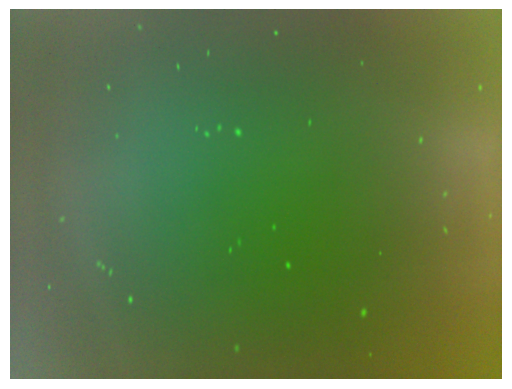

In [20]:
import cv2
import matplotlib.pyplot as plt
import albumentations as A

# Load and convert image
img_path = '/kaggle/working/original_bacteria_dataset/images/10.png'
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Show augmented image
plt.imshow(image)
plt.axis('off')
plt.show()


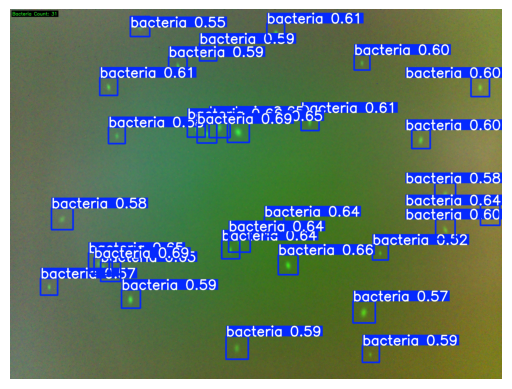

In [22]:
import cv2
import matplotlib.pyplot as plt
import albumentations as A

# Load and convert image
img_path = '/kaggle/working/bacteria_count_10_31.jpg'
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Show augmented image
plt.imshow(image)
plt.axis('off')
plt.show()
